# About
`MS plot` examples for the S&P 500.

### Summary
1. Load S&P 500 returns
2. MS Plot in one line using `fattails`
3. Validation
4. Detailed Calculation

### Context
In chapter 10 of the Technical Incerto there is an MS Plot for the SP500. This notebook shows how to replicate that using python.

An MS plot displays the cumulative max/sum ratio. In the Technical Incerto this plot is used to analyse moments. It can also be applied more broadly to any numeric dataset.

In [1]:
import fattails
import numpy as np
import pandas as pd

# Helper Function

In [2]:
def get_SP500_daily_returns(data_source):
    """Load time series of SP500 daily returns from finance.yahoo.com
    
    Parameters
    ----------
    data_source : str
        URL or path to csv file.    
    
    Returns
    -------
    daily_return : Pandas Series
    """

    # Load Dataset
    price_data = pd.read_csv(data_source, index_col=0, parse_dates=True)    
    
    # Select Closing Prices
    close_price = price_data.Close
    
    # Calculate Daily Return
    daily_return = close_price / close_price.shift(1) - 1
    
    # Remove NaN value
    ## The first day has no prior day so return is NaN
    assert daily_return.isna().sum() == 1  
    daily_return.dropna(inplace=True)

    return daily_return

# Fetch S&P 500 Returns

Calculate the historic daily returns. For context, a value of 0.01 indicates a 1% increase in value on the specified day.

In [3]:
# Calculate Returns
# This particular link captures 60 years from 1960 to 2019 end.
data_source = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=-315619200&period2=1577836800&interval=1d&events=history&includeAdjustedClose=true'

daily_returns = get_SP500_daily_returns(data_source)
daily_returns

Date
1960-01-05    0.008012
1960-01-06   -0.004305
1960-01-07   -0.007318
1960-01-08   -0.003183
1960-01-11   -0.012269
                ...   
2019-12-24   -0.000195
2019-12-26    0.005128
2019-12-27    0.000034
2019-12-30   -0.005781
2019-12-31    0.002946
Name: Close, Length: 15101, dtype: float64

# Express Plot

You can quickly plot the Max/Sum ratio of your dataset's moments using the `fattails.plot_MS_moments()`.

These plots show the cumulative Max/Sum ratio. As you go right on the x axis, this ratio is recalculated with increasing sample size.

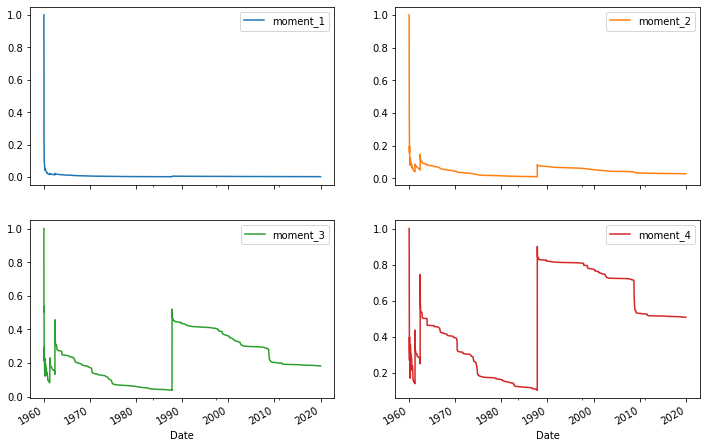

In [4]:
fattails.plot_MS_moments(daily_returns);

# Validate

##### Comparison with Nassim Taleb's Plot

Here is a screenshot of the 4th moment MS plot from the Technical Incerto. We see that it matches with the 4th moment plot above. The dataset we are using starts earlier.

![Title](images/NB27-MS_Plot_SP500_4th_Moment.png)

##### Eyeball the Historic Returns

Let's validate the main jump in the MS plots above. To do this we plot historic returns and look at the most extreme value. The main jump matches with the largest historic loss, a 20% single day loss in 1987.

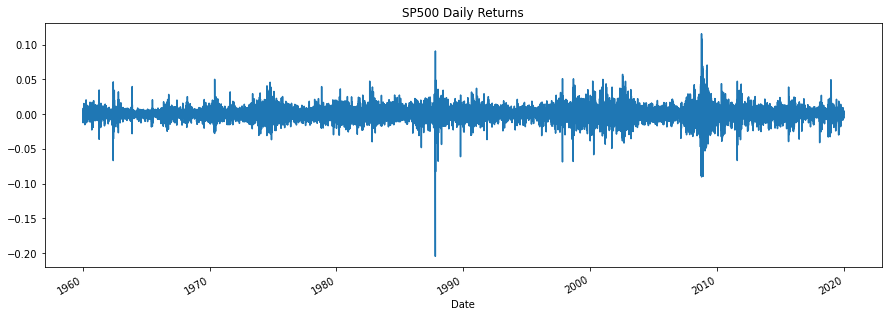

In [5]:
# Plot SP500 daily returns
daily_returns.plot(figsize=[15,5], title='SP500 Daily Returns');

# Detailed Calculation
This section is a more detailed breakdown of the MS moment plot calculations.

First we calculate the moments from daily returns. Moments 1,2,3 and 4 correspond to return, variance, skew and kurtosis respectively. There's a slight difference in that these moments are not centered. I impose absolute values so that all moments are positive.

In [6]:
# Calculate Moments
moments_df = fattails.metrics.calculate_moments(daily_returns)
moments_df

,moment_1,moment_2,moment_3,moment_4
Date,,,,
1960-01-05,0.008012,6.419217e-05,5.143077e-07,4.120634e-09
1960-01-06,0.004305,1.853574e-05,7.980222e-08,3.435737e-10
1960-01-07,0.007318,5.354598e-05,3.918234e-07,2.867172e-09
1960-01-08,0.003183,1.013210e-05,3.225145e-08,1.026595e-10
1960-01-11,0.012269,1.505261e-04,1.846791e-06,2.265810e-08
...,...,...,...,...
2019-12-24,0.000195,3.820000e-08,7.466123e-12,1.459240e-15
2019-12-26,0.005128,2.629809e-05,1.348610e-07,6.915897e-10
2019-12-27,0.000034,1.154973e-09,3.925164e-14,1.333963e-18


Now we calculate the ratio of Max/Sum. A value near Zero indicates that the maximum value doesn't have much effect on the sample average. A value above 0.5 indicates that >50% of the sample average's magnitude is due to one single datapoint. Values close to 1 indicate that your sample average is very sensitive and likely to vary between samples.

In [7]:
# Calculate Max/Sum Ratio
max_over_sum_df = moments_df.apply(fattails.metrics.max_over_sum)
max_over_sum_df

,moment_1,moment_2,moment_3,moment_4
Date,,,,
1960-01-05,1.000000,1.000000,1.000000,1.000000
1960-01-06,0.650466,0.775943,0.865678,0.923038
1960-01-07,0.408050,0.471053,0.521646,0.562054
1960-01-08,0.351128,0.438453,0.505122,0.554293
1960-01-11,0.349673,0.506938,0.644610,0.752957
...,...,...,...,...
2019-12-24,0.002019,0.028031,0.183397,0.508021
2019-12-26,0.002019,0.028031,0.183397,0.508021
2019-12-27,0.002019,0.028031,0.183397,0.508021


Plot the MS plot once more. This time we plot from a dataframe which has all the calculated values. 

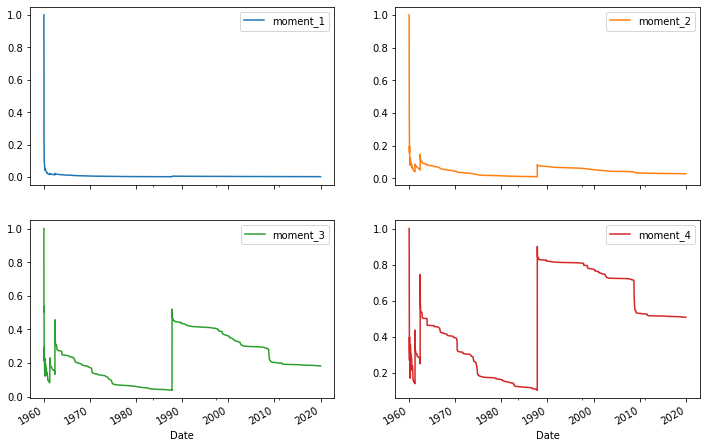

In [8]:
# Plot Max over Sum
max_over_sum_df.plot(subplots=True, layout=[2,2], figsize=[12.0, 8.0]);

##### Comment
Why not center the moments?

My guess is that the book doesn't center the moments because the average return $\bar{x}$ is near zero.

In [9]:
# Calculate the average return
daily_returns.mean()

0.0003137842852293536

Average daily return is 5% of mean deviation:

In [10]:
# Calculate Mean over Mean Deviation
daily_returns.mean() / fattails.mad(daily_returns)

0.04681360997613759